<a href="https://colab.research.google.com/github/kavyajeetbora/time_series_deeplearning.ai/blob/main/week2/modelling_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Creating synthetic time series

In [2]:
def plot_series(time,series,format="-",start=0,end=None, label=None):
    plt.plot(time[start:end],series[start:end],format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(season_time*3))

def seasonality(time, period, amplitude, phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=42):
    rnd = np.random.RandomState(seed)
    return noise_level * rnd.randn(len(time))

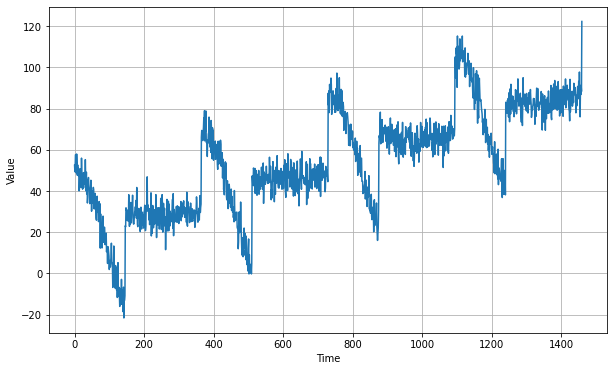

In [3]:
time = np.arange(365*4+1,dtype="float32")
baseline = 10
amplitude = 40
slope=0.05
noise_level = 5

## create a time series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
## update with noise
series += noise(time, noise_level=noise_level,seed=42) 

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

## Preparing the features and labels for training

In [4]:
## splitting the dataset into train and test datasets:
split_time = 1000
train_time = time[0:split_time]
valid_time = time[split_time:]
x_train = series[0:split_time]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size=1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(batch_size))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda x: (x[:-1], x[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Modeling the time series

In [6]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
layer1 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer1])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights {}".format(model.get_weights()))

Layer weights [array([[ 0.01983334],
       [-0.02655897],
       [-0.02173085],
       [-0.0146284 ],
       [ 0.03631057],
       [-0.01298547],
       [ 0.02037212],
       [ 0.02291566],
       [-0.04702372],
       [ 0.06081507],
       [-0.0050312 ],
       [-0.03307639],
       [-0.01086104],
       [-0.00175013],
       [ 0.00168968],
       [ 0.08034496],
       [ 0.04207864],
       [ 0.19496939],
       [ 0.24766426],
       [ 0.4427633 ]], dtype=float32), array([0.0117743], dtype=float32)]
CPU times: user 18.3 s, sys: 3.04 s, total: 21.4 s
Wall time: 14.9 s


These are the layer weights and one bias weight

## Prediction of time series:

In [7]:
model.predict(series[:window_size][np.newaxis])

array([[44.892143]], dtype=float32)

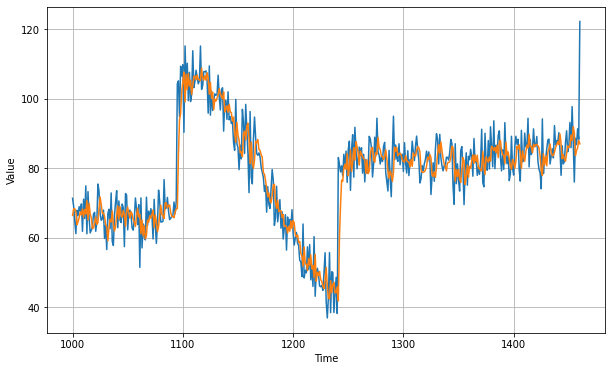

CPU times: user 57.2 s, sys: 818 ms, total: 58 s
Wall time: 57.5 s


In [8]:
%%time
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


## extracting only the validation part from the predictions
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(valid_time, x_valid, label="time series validation set")
plot_series(valid_time, results, label="predictions")
plt.show()

## Evaluation of the model

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.92134

## Deep neural network training, tuning and prediction

In [10]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model2.fit(dataset, epochs=100, verbose=0)
print("Layer weights {}".format(model2.get_weights()))

Layer weights [array([[-0.08868992,  0.09158829,  0.3606538 , -0.3745166 ,  0.37021887,
        -0.2683235 , -0.37939897,  0.1951684 ,  0.4284566 , -0.12291426],
       [ 0.15560196, -0.2659174 , -0.05389207, -0.10353624, -0.12248489,
         0.3309647 , -0.17019004,  0.38338172, -0.16915447,  0.05082397],
       [ 0.38688967,  0.37348542, -0.24044502, -0.44173694, -0.09384936,
        -0.29559848, -0.25996414, -0.3396255 , -0.10162649, -0.26559457],
       [-0.4258787 , -0.29414594, -0.32751334,  0.35395515,  0.11387512,
         0.14544126, -0.25278708, -0.19262132, -0.41872844,  0.0181641 ],
       [-0.18040833,  0.34107468,  0.44381195, -0.28063717, -0.01862009,
        -0.30711064,  0.15810446, -0.16274372,  0.07551429,  0.1412149 ],
       [ 0.36667445,  0.05163705,  0.22170213,  0.2683107 , -0.40747964,
         0.3266301 ,  0.20995374, -0.22205682,  0.3005128 ,  0.32501784],
       [ 0.40688264, -0.28681052, -0.09823788,  0.00131956, -0.05900281,
        -0.1195792 , -0.207453

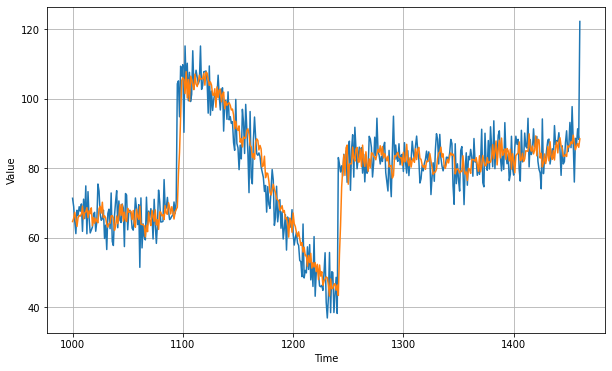

CPU times: user 56.3 s, sys: 913 ms, total: 57.2 s
Wall time: 56.7 s


In [11]:
%%time
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model2.predict(series[time:time+window_size][np.newaxis]))


## extracting only the validation part from the predictions
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(valid_time, x_valid, label="time series validation set")
plot_series(valid_time, results, label="predictions")
plt.show()

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8688693

### Tuning the learning rate with learning rate scheduler

it will change the learning rates to a value based on the epoch number

In [20]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model2.fit(dataset, epochs=100, callbacks=[lr_scheduler], verbose=False)

CPU times: user 20.1 s, sys: 3.27 s, total: 23.4 s
Wall time: 16.3 s


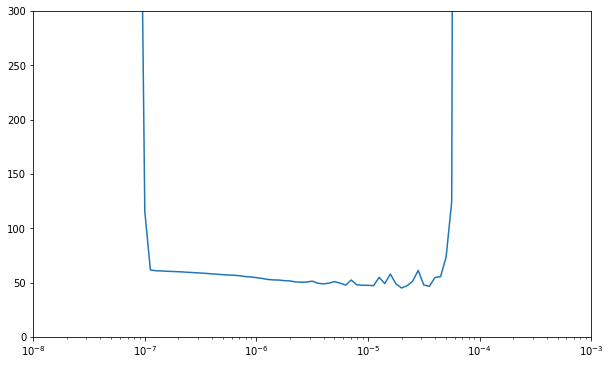

In [22]:
plt.figure(figsize=(10,6))
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3,0,300])
plt.show()

In [23]:
best_lr = lrs[np.argmin(history.history["loss"])]
best_lr

1.995262314968879e-05

In [33]:
%%time
window_size=30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])
model3.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9))
history = model3.fit(dataset, epochs=500, verbose=False)

CPU times: user 1min 41s, sys: 16.8 s, total: 1min 57s
Wall time: 1min 21s


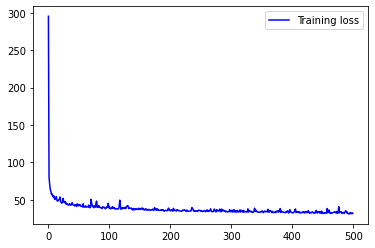

In [34]:
loss = history.history["loss"]
epochs = range(500)
plt.plot(epochs, loss, "b", label="Training loss")
plt.legend()
plt.show()

We can see that the loss is decreasing as the epochs are increasing, it means our model is learning and going in the right direction

### plotting the tuned model

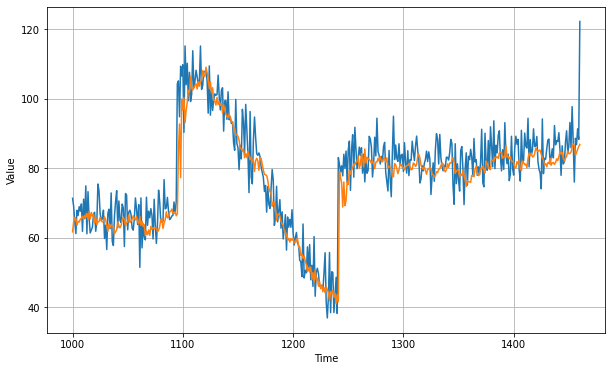

CPU times: user 59.5 s, sys: 738 ms, total: 1min
Wall time: 59.7 s


In [35]:
%%time
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model3.predict(series[time:time+window_size][np.newaxis]))


## extracting only the validation part from the predictions
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(valid_time, x_valid, label="time series validation set")
plot_series(valid_time, results, label="predictions")
plt.show()

### evaluating the tuned model

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.951344